# Independent Component Analysis (ICA)

## Model Specification

ICA applied to multivariate data looks for sequence of orthogonal projections such that the projected data look as far from Gaussian as possible. With pre-whitened data $X\in\mathbb{R}^{p\times N}$, i.e. $Cov(X)=I$, this amounts to looking for components that are as independent as possible. Mathematically, for data $X$ we need to find an orthogonal matrix $A\in\mathbb{R}^{p\times p}$ such that the components of the vector random variables $S=A^{\top}X$ are independent and non-Gaussian (the reason we need non-Gaussian is clear below).

The method to ascertain non-Gaussian is by entropy. Define the differential entropy $H$ of a random variable $Y$:

$$H(Y)=-\int g(y)\log g(y)dy$$.

A well-known results in information theory says that among all continuous random variables with equal variance, Gaussian variables have the maximum entropy. Finally, we define mutual information $I(Y)$ to be the measure of dependence:

$$I(Y)=\sum_{j=1}^pH(Y_j)-H(Y).$$

$I(Y)$ is also the Kullback-Leibler distance between density $g(y)$ and its independence version. With $Cov(X)=I$ and $A$ orthogonal, the Jacabian transform property of density functions yields

$$I(Y) = \sum_{j=1}^pH(Y_j) - H(X) - \log|det A| = \sum_{j=1}^pH(Y_j) - H(X).$$

To maximize the independence of components of $Y$, it is equivant to maximize $I(Y)$ above, which in turns is to maximize $Y_j$'s departure from Gaussianity.

### Variants and Generalizations

For convenience, a **negentropy** measure $J(Y_j)$ is often used in place of $H(Y_j)$ above:

$$J(Y_j) = H(Z) - H(Y_j),$$

where $Z$ is the standard Gaussian. This can be viewed as a measure of how $Y_j$ departs to Gaussianity. Simple approximations to negentropy are proposed and optimized on data. For instance, 

$$J(Y_j) \approx [EG(Y_j)-EG(Z)]^2,$$

where $G(u)=\frac{1}{a}\log\cosh(au)$ for $1<a<2$. The choice of such option is available in `FastICA` in `sklearn`; see sections below for more information.

## Theoretical Properties

### Advantages

- The non-Gaussian property allows ICA to pin down the transform $A$ uniquely, vs. in [factor analysis](factor_analysis.ipynb) where factors are unique up to a rotation. More specifically, ICA requires independence, which determines all cross-moments in the multivariate distribution, while uncorrealtedness only determines up to the second cross-moments. This extra restriction on moments allows us to identify $A$ uniquely.

### Disadvantages

### Relation to Other Models

In the sense of distilling the latent variables $S$, ICA is similar to [factor analysis](factor_analysis.ipynb), but there are several differences. 
- ICA assumes $S$ to be non-Gaussian and independent, while in factor analysis $S$ is Gaussian and uncorrelated (independence by deduction). This brings about one advantage of ICA over factor analysis; see section about advantages.
- The dimension of latent variables decreases $q<p$ in factor analysis, but ICA does not perform dimension reduction.

There is also a fair comparason between ICA and [PCA](PCA.ipynb). 

- ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal in the original feature space, but they are orthogonal in the whitened feature space, in which all directions correspond to the same variance.

- PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

For an illustration, see the section on visualization below.

## Empirical Performance

### Advantages and Disadvantages

## Implementation Details and Practical Tricks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

**Selected Parameters**

Many of the parameters of `FastICA` are shared with `PCA`, except for the few below.

- **`fun`** : string or function, optional. Default: `‘logcosh’`

The functional form of the G function used in the approximation to neg-entropy. Could be either ‘logcosh’, ‘exp’, or ‘cube’. You can also provide your own function. It should return a tuple containing the value of the function, and of its derivative, in the point. 

Example:

`def my_g(x):
return x ** 3, 3 * x ** 2`

- `**fun_args**` : dictionary, optional

Arguments to send to the functional form. If empty and if `fun=’logcosh’`, `fun_args` will take value `{‘alpha’ : 1.0}`.

**Selected Attributes**

- **`components_`** : 2D array, shape `(n_components, n_features)`

    The unmixing matrix $A^{\top}$: $S=A^{\top}X$.

- **`mixing_`** : array, shape `(n_features, n_components)`

    The mixing matrix $A$: $X=AS$

**Selected Methods**

- **`fit_transform(X,[y])`**: the fitted signals `S` of `X`.

## Use Cases

ICA is powerful in dealing with **cocktail party problem**, or **blind source separation**. More specifically, ICA is used to estimate sources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording the mixed signals. ICA is used to recover the sources ie. what is played by each instrument. See below for an example, which is taken from [sklearn document](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py).

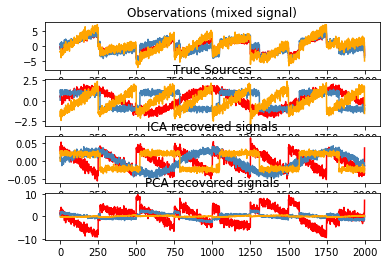

In [2]:
from sklearn.decomposition import PCA

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

#plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

## Results Interpretation, Metrics and Visualization

Visualizing ICA can be done in the similar approaches outlined in [PCA](PCA.ipynb).

- Display the unmixing matrix $A^{\top}$ in the feature space, also called ‘geometric ICA’ in `sklearn`. 

- Show the first two signals, or the first two columns of $S$. Alternatively, you can also choose a few components and produce scatterplot from one to another; see Figure 14.39 in ESL for an example.

- Display data points that attain extreme scroes on the components; see Figure 14.40 in ESL.

Here we simulate independent sources using a highly non-Gaussian process, 2 student T with a low number of degrees of freedom (top left figure). We mix them to create observations (top right figure). In this raw observation space, directions identified by PCA are represented by orange vectors. We represent the signal in the PCA space, after whitening by the variance corresponding to the PCA vectors (lower left). Running ICA corresponds to finding a rotation in this space to identify the directions of largest non-Gaussianity (lower right).

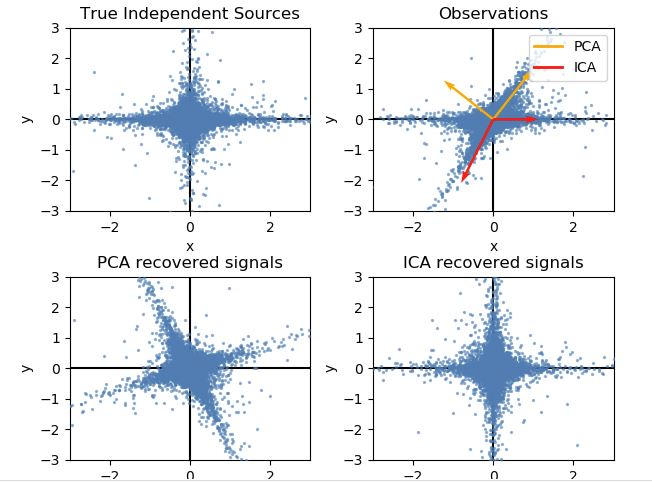

In [3]:
from IPython.display import Image
import os.path
path = r"C:\Users\Yixian\Documents\machine-learning"
file = "ica_vs_pca.JPG"
Image(filename = os.path.join(path, file))

## References

- ESL Section 14.7
- [scikit-learn Document 2.5.5](http://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica)

### Further Reading

## Misc.